# Merged model evaluation

In [2]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np




/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
files = sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_*space*'))

list_of_dfs = []
for f, file in enumerate(files):
    t = pd.read_csv(file, delimiter='\t')
    list_of_dfs.append(t)
    t['source'] = file.split('/')[-1].strip('.tsv')

D = pd.concat(list_of_dfs, ignore_index=True).reset_index(drop=True)
D.drop_duplicates(subset=D.columns.difference(['source']))

D.shape

(8092, 15)

In [12]:
crits = ['dcbc_group','dcbc_indiv']

# recover info
for r,row in D.iterrows():
    print(r, row.source)
    new = fp.recover_info(row, info_type='evaluation_info')
    # print(r, new.train_data)
    D.iloc[r] = new
                    

figsize = (10,10)
# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r,row in D.iterrows():
    if row['atlas'] == 'MNISymC2':
        if 'fromC3' in row['source']:
            D.loc[r,'origin'] = 'clustered_in_C3'
        elif 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'
    elif row['atlas'] == 'MNISymC3':
        if 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'

# Determine whether model was trained on rest, task and rest, or task only
for r,row in D.iterrows():
    if ['HCP'] == row['train_data']:
        D.loc[r, 'trained_on'] = 'rest'
    elif 'HCP' in row['train_data']:
        D.loc[r, 'trained_on'] = 'task_and_rest'
    else:
        D.loc[r, 'trained_on'] = 'task'
        

# Determine whether model was tested on rest, task and rest, or task only
for r, row in D.iterrows():
    if 'HCP' == row['test_data']:
        D.loc[r, 'tested_on'] = 'rest'
    else:
        D.loc[r, 'tested_on'] = 'task'

# Leave-one-out / All / Individual indicator
for r, row in D.iterrows():
    n_train_datasets = len(row['train_data'])
    if n_train_datasets==1:
        D['train_type'] = 'indiv'
    elif n_train_datasets==6:
        D['train_type'] = 'loo'
    elif n_train_datasets==7:
        if 'HCP' in row['train_data']:
            D['train_type'] = 'loo'
        else:
            D['train_type'] = 'all'
    elif n_train_datasets==8:
        D['train_type'] = 'all'

# Symmetric / Asymmetric indicator
for r, row in D.iterrows():
    if 'sym' in row['source']:  
        D.loc[r, 'symmetry'] = 'symmetric'
    else:
        D.loc[r, 'symmetry'] = 'asymmetric'


# Cross-validation indicator
for r, row in D.iterrows():
    train_test_match = [data in row.test_data for data in row.train_data]
    if np.any(train_test_match):
        D.loc[r, 'cv'] = False
    else:
        D.loc[r, 'cv'] = True

D.tail()


0 eval_on-rest_sym_Hc_space-MNISymC3_K-10
1 eval_on-rest_sym_Hc_space-MNISymC3_K-10
2 eval_on-rest_sym_Hc_space-MNISymC3_K-10
3 eval_on-rest_sym_Hc_space-MNISymC3_K-10
4 eval_on-rest_sym_Hc_space-MNISymC3_K-10
5 eval_on-rest_sym_Hc_space-MNISymC3_K-10
6 eval_on-rest_sym_Hc_space-MNISymC3_K-10
7 eval_on-rest_sym_Hc_space-MNISymC3_K-10
8 eval_on-rest_sym_Hc_space-MNISymC3_K-10
9 eval_on-rest_sym_Hc_space-MNISymC3_K-10
10 eval_on-rest_sym_Hc_space-MNISymC3_K-10
11 eval_on-rest_sym_Hc_space-MNISymC3_K-10
12 eval_on-rest_sym_Hc_space-MNISymC3_K-10
13 eval_on-rest_sym_Hc_space-MNISymC3_K-10
14 eval_on-rest_sym_Hc_space-MNISymC3_K-10
15 eval_on-rest_sym_Hc_space-MNISymC3_K-10
16 eval_on-rest_sym_Hc_space-MNISymC3_K-10
17 eval_on-rest_sym_Hc_space-MNISymC3_K-10
18 eval_on-rest_sym_Hc_space-MNISymC3_K-10
19 eval_on-rest_sym_Hc_space-MNISymC3_K-10
20 eval_on-rest_sym_Hc_space-MNISymC3_K-10
21 eval_on-rest_sym_Hc_space-MNISymC3_K-10
22 eval_on-rest_sym_Hc_space-MNISymC3_K-10
23 eval_on-rest_sym_H

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
8087,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,19,True,0.086474,0.166727,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,loo,symmetric,True
8088,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,20,True,0.090322,0.140934,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,loo,symmetric,True
8089,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,21,True,0.068447,0.096636,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,loo,symmetric,True
8090,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,22,True,0.022585,0.136564,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,loo,symmetric,True
8091,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,23,True,0.085314,0.137191,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,loo,symmetric,True


In [13]:
D[(D.train_type=='loo') & (D.cv == False)]

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
0,sym_Hc,MNISymC3,10,[HCP],123761592.0,0,True,0.233822,0.248954,Models_03,...,half,1,HCP,eval_on-rest_sym_Hc_space-MNISymC3_K-10,data,rest,rest,loo,symmetric,False
1,sym_Hc,MNISymC3,10,[HCP],123761592.0,1,True,0.087236,0.026265,Models_03,...,half,1,HCP,eval_on-rest_sym_Hc_space-MNISymC3_K-10,data,rest,rest,loo,symmetric,False
2,sym_Hc,MNISymC3,10,[HCP],123761592.0,2,True,0.001129,0.054986,Models_03,...,half,1,HCP,eval_on-rest_sym_Hc_space-MNISymC3_K-10,data,rest,rest,loo,symmetric,False
3,sym_Hc,MNISymC3,10,[HCP],123761592.0,3,True,0.124124,0.172710,Models_03,...,half,1,HCP,eval_on-rest_sym_Hc_space-MNISymC3_K-10,data,rest,rest,loo,symmetric,False
4,sym_Hc,MNISymC3,10,[HCP],123761592.0,4,True,0.107988,0.070580,Models_03,...,half,1,HCP,eval_on-rest_sym_Hc_space-MNISymC3_K-10,data,rest,rest,loo,symmetric,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,sym_MdPoNiIbWmDeSo,MNISymC3,80,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",20815934.0,3,True,0.155667,0.599840,Models_03,...,half,2,Somatotopic,eval_on-task_sym_MdPoNiIbWmDeSo_space-MNISymC3...,data,task,task,loo,symmetric,False
6548,sym_MdPoNiIbWmDeSo,MNISymC3,80,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",20815934.0,4,True,0.256672,0.653818,Models_03,...,half,2,Somatotopic,eval_on-task_sym_MdPoNiIbWmDeSo_space-MNISymC3...,data,task,task,loo,symmetric,False
6549,sym_MdPoNiIbWmDeSo,MNISymC3,80,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",20815934.0,5,True,0.129952,0.427531,Models_03,...,half,2,Somatotopic,eval_on-task_sym_MdPoNiIbWmDeSo_space-MNISymC3...,data,task,task,loo,symmetric,False
6550,sym_MdPoNiIbWmDeSo,MNISymC3,80,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",20815934.0,6,True,0.128958,0.409529,Models_03,...,half,2,Somatotopic,eval_on-task_sym_MdPoNiIbWmDeSo_space-MNISymC3...,data,task,task,loo,symmetric,False


In [14]:

np.any(D.train_type=='loo')
# D[(D.tested_on=='task') & (D.trained_on=='task')]

True

### Comparing pure task-trained, rest-and-task-trained, and rest-trained parcellations

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19787/516726815.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D[D.cv==True].groupby(['atlas','origin', 'trained_on', 'K']).mean()


train_loglik   subj_num  common_kappa  \
atlas    origin    trained_on    K                                           
MNISymC2 clustered task          32  6.449879e+07  49.500000           1.0   
MNISymC3 data      rest          10  1.237616e+08  10.801802           1.0   
                                 20  1.267122e+08  10.801802           1.0   
                                 32  1.283649e+08  10.801802           1.0   
                                 34  1.285610e+08  10.801802           1.0   
                                 40  1.290849e+08  10.801802           1.0   
                                 68  1.305074e+08  10.801802           1.0   
                   task          10  1.618215e+07  10.801802           1.0   
                                 20  1.684899e+07  11.368932           1.0   
                                 34  1.763498e+07  10.801802           1.0   
                                 40  1.781318e+07  10.801802           1.0   
                                 68  1.841345e+07  10.801802           1.0   
                   task_and_rest 10  1.398899e+08  10.801802           1.0   
                                 20  1.436830e+08  10.801802           1.0   
                                 34  1.461622e+08  10.801802           1.0   
                                 40  1.468522e+08  10.801802           1.0   
                                 68  1.488512e+08  10.801802           1.0   

                                     dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin    trained_on    K                                           
MNISymC2 clustered task          32    0.075610    0.141739             1.5  
MNISymC3 data      rest          10    0.096260    0.122273             1.5  
                                 20    0.087596    0.170079             1.5  
                                 32    0.098028    0.182462             1.5  
                                 34    0.100316    0.181911             1.5  
                                 40    0.091794    0.179383             1.5  
                                 68    0.098571    0.185343             1.5  
                   task          10    0.076113    0.126742             1.5  
                                 20    0.091555    0.165617             1.5  
                                 34    0.078599    0.171876             1.5  
                                 40    0.085183    0.173965             1.5  
                                 68    0.086250    0.187621             1.5  
                   task_and_rest 10    0.102754    0.132501             1.5  
                                 20    0.092638    0.160373             1.5  
                                 34    0.104862    0.171338             1.5  
                                 40    0.100822    0.179936             1.5  
                                 68    0.107196    0.190029             1.5

<Figure size 1000x1000 with 0 Axes>

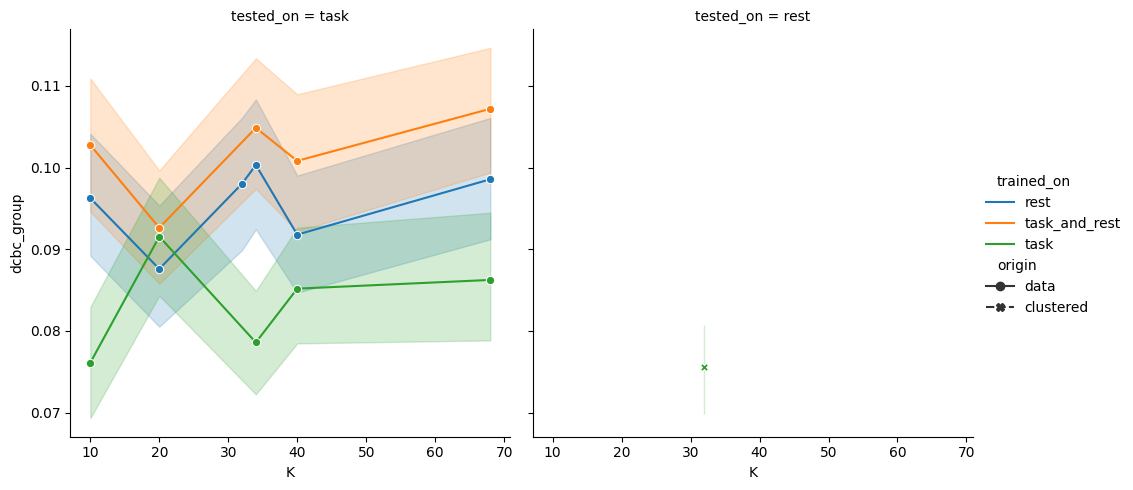

<Figure size 1000x1000 with 0 Axes>

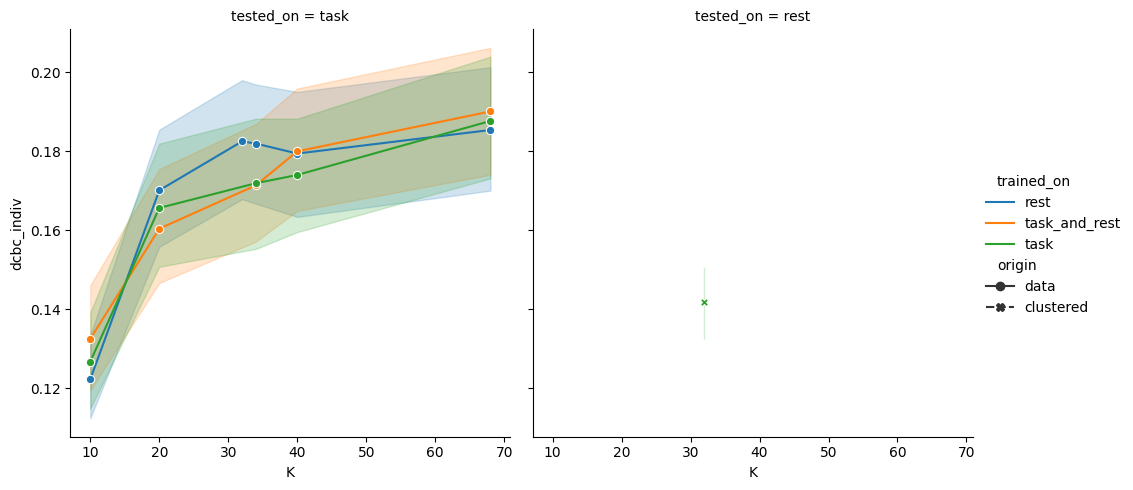

In [ ]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv==True], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

D[D.cv==True].groupby(['atlas','origin', 'trained_on', 'K']).mean()


<Figure size 1000x1000 with 0 Axes>

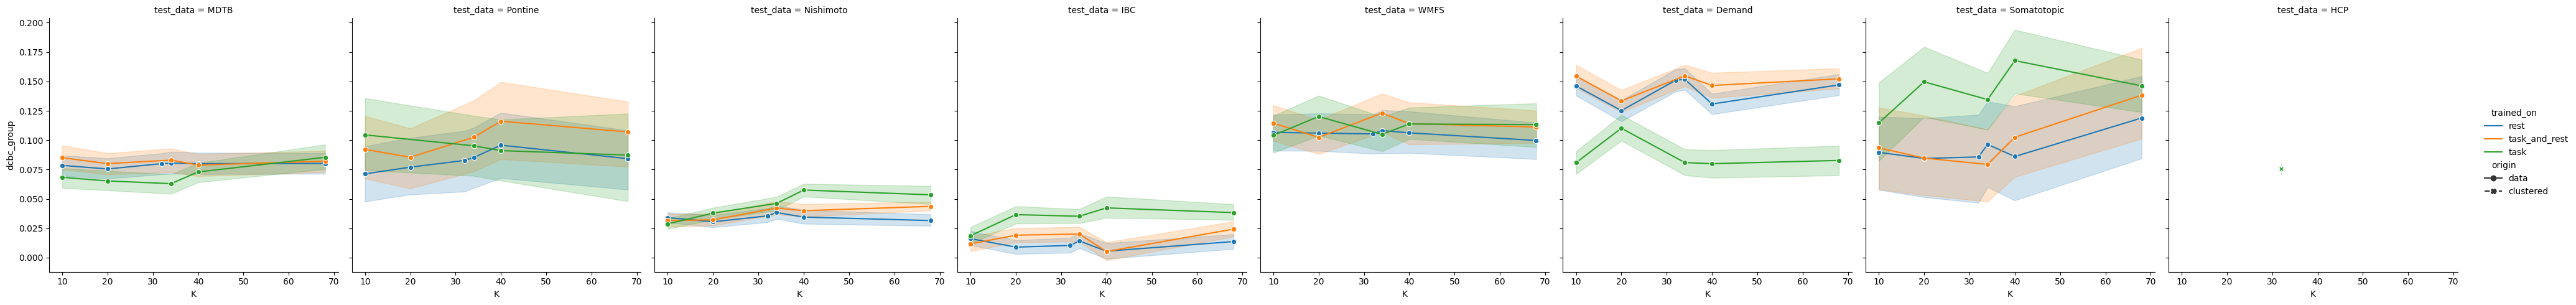

<Figure size 1000x1000 with 0 Axes>

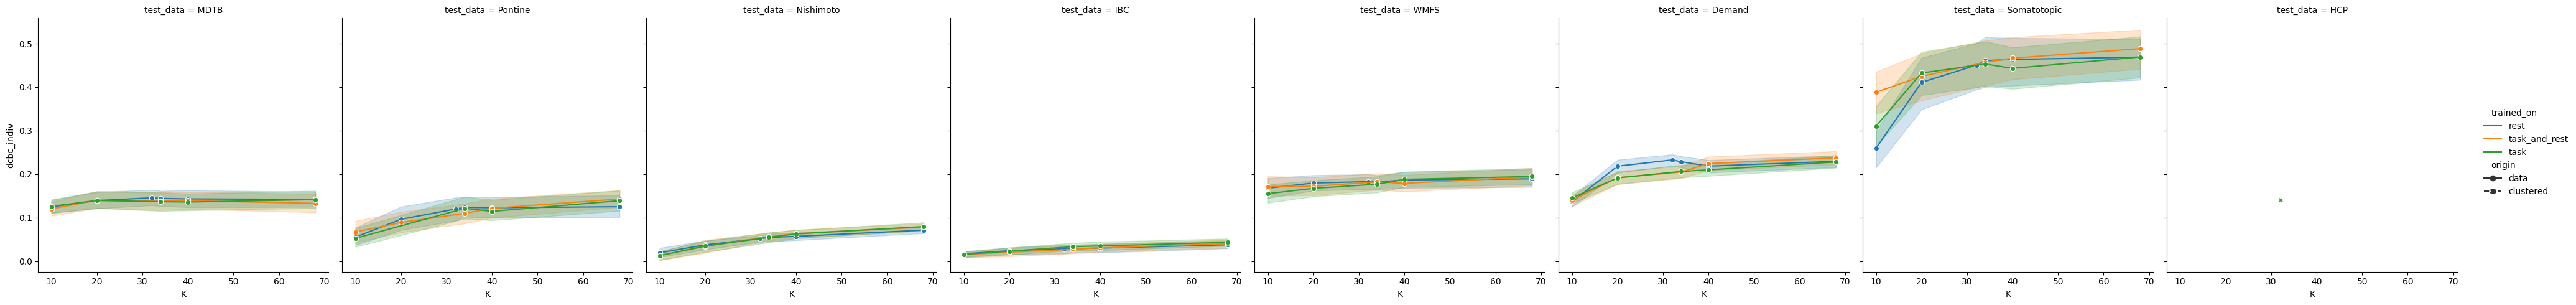

In [ ]:

plt.figure(figsize=figsize)
f = sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_group", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)

plt.figure(figsize=figsize)
f = sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)
# f.set(ylim=(0, 0.4))


In [ ]:
D[(D.cv==True) & (D.tested_on=='task')].tail()

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
8531,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,19,True,0.086474,0.166727,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8532,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,20,True,0.090322,0.140934,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8533,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,21,True,0.068447,0.096636,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8534,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,22,True,0.022585,0.136564,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8535,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,23,True,0.085314,0.137191,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True


<Figure size 1000x1000 with 0 Axes>

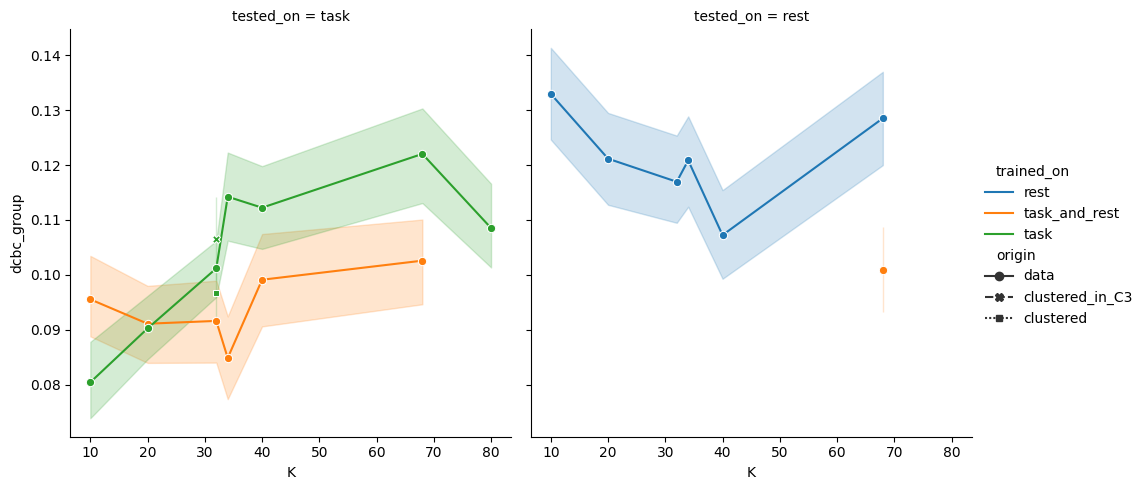

<Figure size 1000x1000 with 0 Axes>

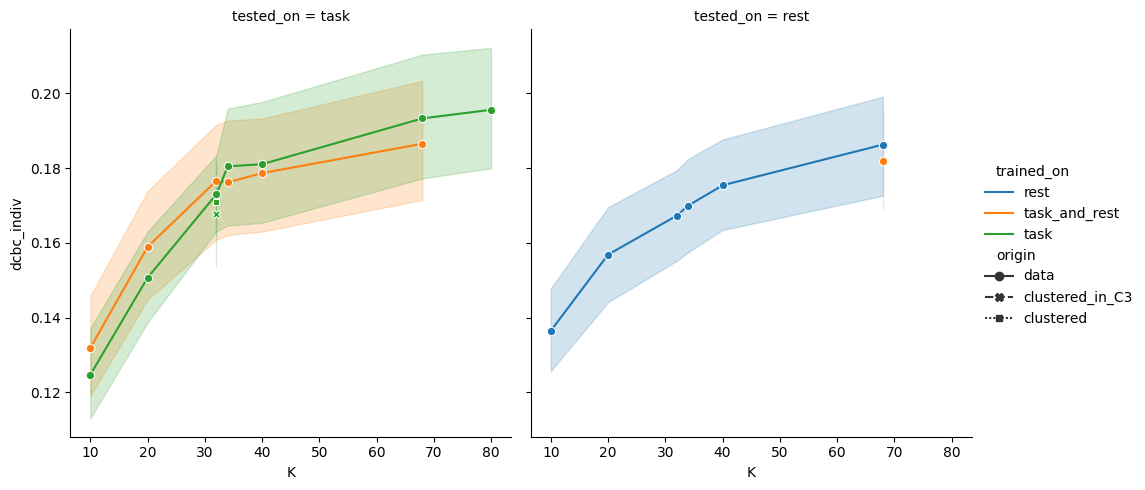

In [ ]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_group", col="test_data", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_indiv", col="test_data", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)


In [19]:
ex = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/nettekoven_68/eval_on-task+rest_existing.tsv', sep='\t')

# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r, row in ex.iterrows():
    model_parts = row.model_name.split('_')
    space = row.model_name.split('space-')[1].strip('_')
    train_data = row.model_name.split('_space')[0]
    ex.loc[r, 'atlas'] = space
    ex.loc[r, 'train_data'] = train_data

# Determine whether model was trained on rest, task and rest, or task only
for r, row in ex.iterrows():

    if 'atl-Anatom' == row['train_data']:
        ex.loc[r, 'trained_on'] = 'anatomy'
    elif row['train_data'] in ['atl-Buckner7', 'atl-Buckner17', 'atl-Ji10']:
        ex.loc[r, 'trained_on'] = 'rest'
    else:
        ex.loc[r, 'trained_on'] = 'task'


# Determine whether model was tested on rest, task and rest, or task only
for r, row in ex.iterrows():
    if 'HCP' == row['test_data']:
        ex.loc[r, 'tested_on'] = 'rest'
    else:
        ex.loc[r, 'tested_on'] = 'task'

ex['dcbc_group'] = ex['dcbc']

ex.head()


,fit_type,model_name,test_data,subj_num,dcbc,atlas,train_data,trained_on,tested_on,dcbc_group
0,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,0,0.098281,MNISymC3_K-10,asym_Md,task,task,0.098281
1,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,1,0.095214,MNISymC3_K-10,asym_Md,task,task,0.095214
2,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,2,0.049849,MNISymC3_K-10,asym_Md,task,task,0.049849
3,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,3,0.213206,MNISymC3_K-10,asym_Md,task,task,0.213206
4,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,4,0.090611,MNISymC3_K-10,asym_Md,task,task,0.090611


In [52]:
columns_to_keep = ['model_name', 'atlas', 'trained_on', 'tested_on', 'dcbc_group', 'train_data', 'test_data']
result = pd.concat([D[columns_to_keep], ex[columns_to_keep]])

# Make train_data list entries into strings
for r, row in result.iterrows():
    if type(row.train_data) == list:
        result.loc[r, 'train_data'] = '_'.join(row.train_data)


In [42]:
result.head()


,model_name,atlas,trained_on,tested_on,dcbc_group,train_data,test_data
0,sym_Hc,MNISymC3,rest,rest,0.233822,[HCP],HCP
1,sym_Hc,MNISymC3,rest,rest,0.087236,[HCP],HCP
2,sym_Hc,MNISymC3,rest,rest,0.001129,[HCP],HCP
3,sym_Hc,MNISymC3,rest,rest,0.124124,[HCP],HCP
4,sym_Hc,MNISymC3,rest,rest,0.107988,[HCP],HCP


In [55]:
result.tail()
# result.train_data.unique()



,model_name,atlas,trained_on,tested_on,dcbc_group,train_data,test_data
1261,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,rest,rest,0.131517,MDTB_Pontine_Nishimoto_IBC_WMFS_Demand_Somatot...,HCP
1262,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,rest,rest,0.147609,MDTB_Pontine_Nishimoto_IBC_WMFS_Demand_Somatot...,HCP
1263,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,rest,rest,0.128097,MDTB_Pontine_Nishimoto_IBC_WMFS_Demand_Somatot...,HCP
1264,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,rest,rest,0.208120,MDTB_Pontine_Nishimoto_IBC_WMFS_Demand_Somatot...,HCP
1265,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,rest,rest,0.150397,MDTB_Pontine_Nishimoto_IBC_WMFS_Demand_Somatot...,HCP


<Figure size 1000x1000 with 0 Axes>

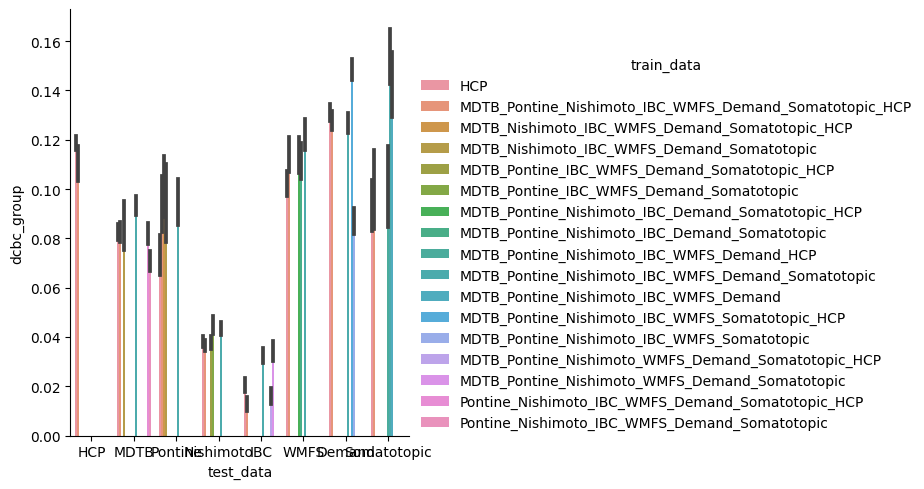

In [53]:

plt.figure(figsize=figsize)
f = sb.catplot(
    data=result, y="dcbc_group", x="test_data", hue="train_data", kind="bar")

# f.set(ylim=(0, 0.4))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_8636/1251526221.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ex.groupby(['train_data', 'tested_on']).mean()


<Figure size 1000x1000 with 0 Axes>

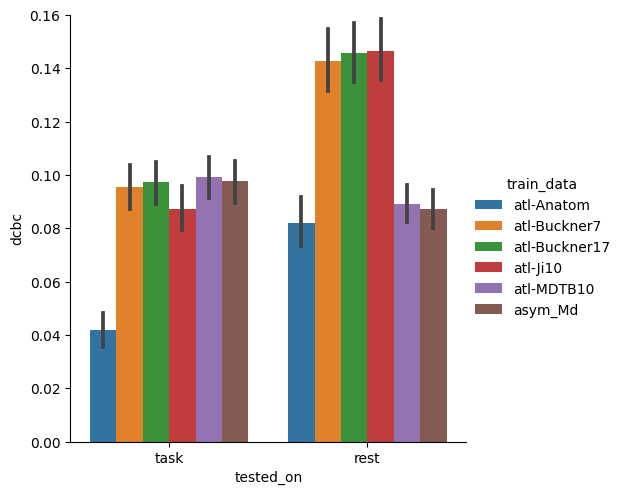

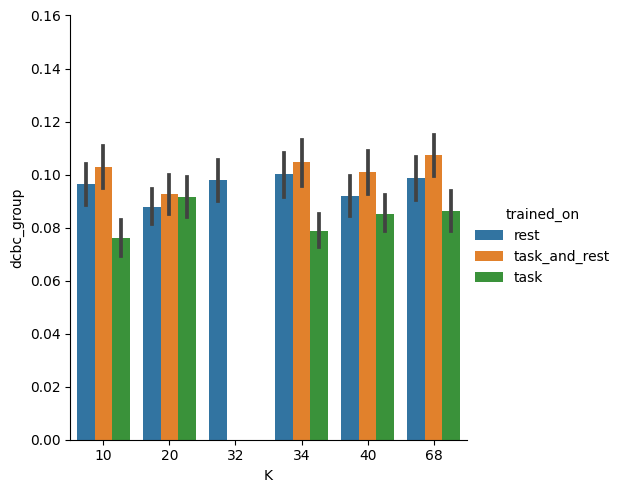

In [67]:

plt.figure(figsize=figsize)


g = sb.catplot(
    data=ex, x="tested_on", y="dcbc", hue="train_data", kind="bar", hue_order=['atl-Anatom', 'atl-Buckner7', 'atl-Buckner17', 'atl-Ji10', 'atl-MDTB10', 'asym_Md'])

ex.groupby(['train_data', 'tested_on']).mean()
g.set(ylim=(0, 0.16))


K=68
g = sb.catplot(
    data=D[(D.cv == True) ], x="K", y="dcbc_group", hue="trained_on", kind="bar")

g.set(ylim=(0, 0.16))
